# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
%load_ext dotenv
%dotenv 
# Add src to path
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib as plt
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error , r2_score
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.ensemble import

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [3]:
fires_dt

#dt = fires_dt.assign(
#    fire = lambda x: (x['area'] > 1)*1)
#dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [4]:
# col_drop = ['area', 'month', 'coord_y', 'day', 'ffmc', 'dc', 'isi']
X = fires_dt.drop(columns='area')


In [5]:
X


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [6]:
# value_to_search = 'nov'
# result = X[X['month'] == value_to_search]
# print(result)

In [7]:
Y = fires_dt['area']

In [8]:
Y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area, Length: 517, dtype: float64

In [9]:
# fires_dt_copy = dt.copy()

# def plot_feature_pairs(data, feature_names, color_labels=None, title_prefix=''):
#     """
#     Helper function to create scatter plots for all possible pairs of features.
    
#     Parameters:
#     - data: DataFrame containing the features to be plotted.
#     - feature_names: List of feature names to be used in plotting.
#     - color_labels: Optional. Cluster or class labels to color the scatter plots.
#     - title_prefix: Optional. Prefix for plot titles to distinguish between different sets of plots.
#     """
#     # Create a figure for the scatter plots
#     plt.figure(figsize=(30, 30))
#     # .subplots(2,7, figsize=(10,8))

#     # Counter for subplot index
#     plot_number = 1
    
#     # Loop through each pair of features
#     for i in range(len(feature_names)-1):
#           #for j in range(i + 1, len(feature_names)):
#        plt.subplot(len(feature_names)-1, len(feature_names)-1, plot_number)
            
#         # Scatter plot colored by labels if provided
#        if color_labels is not None:
#          plt.scatter(data[feature_names[i]], data['fire'], 
#                             c=color_labels, cmap='viridis', alpha=0.7)
#        else:
#          plt.scatter(data[feature_names[i]], data['fire'], alpha=0.7)
            
#        plt.xlabel(feature_names[i])
#        plt.ylabel('Fire')
#        plt.title(f'{feature_names[i]}')
            
#         # Increment the plot number
#        plot_number += 1

#     # Adjust layout to prevent overlap
#     plt.tight_layout()

#     # Show the plot
#     plt.show()

# # Get feature names
# feature_names = fires_dt_copy.columns

# # Use the helper function to plot scatter plots without coloring by cluster labels
# plot_feature_pairs(fires_dt_copy, feature_names)#, title_prefix='Original Data: ')

In [10]:
# fires_dt_std = fires_dt.copy()
# fires_area = fires_dt_std[['area']]

# std_scaler = StandardScaler()

# std_scaler.fit(fires_area)
# scaled_fires_area_np = std_scaler.transform(fires_area)
# scaled_fires_area = pd.DataFrame(scaled_fires_area_np, columns=fires_area.columns)
# scaled_fires_area.describe()



# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [11]:


# num_cols = ['coord_x', 'dmc', 'temp', 'rh', 'wind', 'rain']
num_cols = ['coord_x','coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
label_cols = ['month', 'day']

numeric_transformer_1 = Pipeline([('standardizer', StandardScaler())])
categorical_transformer_1 = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]) # instead use (handle_unknown='infrequent_if_exist')

preproc1 = ColumnTransformer([
    ('numeric_simple', numeric_transformer_1, num_cols),
    ('cat_onehot', categorical_transformer_1, label_cols)
    
])
# preproc1 = ColumnTransformer([
#     ('numeric_simple', StandardScaler(), num_cols),
#     ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), label_cols)
    
# ])
preproc1



ColumnTransformer(transformers=[('numeric_simple',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_onehot',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [12]:
from sklearn.preprocessing import QuantileTransformer

numeric_transformer_2 = Pipeline([('PowerTrans', PowerTransformer(method='yeo-johnson'))])
categorical_transformer_2 = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preproc2 = ColumnTransformer([
    ('numeric_simple', numeric_transformer_2, num_cols),
    ('cat_onehot', categorical_transformer_2, label_cols)
])
# preproc2 = ColumnTransformer([
#     ('numeric_simple', PowerTransformer(method='yeo-johnson'), num_cols),
#     ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), label_cols)
# ])
preproc2

ColumnTransformer(transformers=[('numeric_simple',
                                 Pipeline(steps=[('PowerTrans',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_onehot',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [13]:
# Split the data set into training and testing sets for all pipelines
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [14]:
# Pipeline A = preproc1 + baseline

baseline_a = Pipeline([('reg_model', Ridge())])

pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_a)
])

pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Pipeline(steps=[('reg_model', Ridge())]))])

In [15]:
# Cross-validate Pipeline A for performance

res_pl_a_dict = cross_validate(pipeline_a, X_train, Y_train, cv = 5, scoring = 'neg_mean_squared_error')
res_pl_a = pd.DataFrame(res_pl_a_dict).assign(experiment = 'PL-A')
res_pl_a

,fit_time,score_time,test_score,experiment
0,0.006530,0.001956,-1668.277913,PL-A
1,0.003885,0.001699,-371.217538,PL-A
2,0.006178,0.001810,-1126.319817,PL-A
3,0.003550,0.003311,-7266.565690,PL-A
4,0.005376,0.002398,-704.088086,PL-A


In [16]:
# Pipeline B = preproc2 + baseline

baseline_b = Pipeline([('reg_model', Lasso())])

pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_b)
])

pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('PowerTrans',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Pipeline(steps=[('reg_model', Lasso())]))])

In [17]:
# Cross-validate Pipeline B for performance

# Using cross-validation to check on model performance
res_pl_b_dict = cross_validate(pipeline_b, X_train, Y_train, cv = 5, scoring = 'neg_mean_squared_error')
res_pl_b = pd.DataFrame(res_pl_b_dict).assign(experiment = 'PL-B')
res_pl = pd.concat([res_pl_a, res_pl_b])
res_pl

,fit_time,score_time,test_score,experiment
0,0.006530,0.001956,-1668.277913,PL-A
1,0.003885,0.001699,-371.217538,PL-A
2,0.006178,0.001810,-1126.319817,PL-A
3,0.003550,0.003311,-7266.565690,PL-A
4,0.005376,0.002398,-704.088086,PL-A
0,0.041864,0.014475,-1585.145128,PL-B
1,0.067656,0.026931,-289.180666,PL-B
2,0.020303,0.003377,-761.810344,PL-B
3,0.017655,0.002889,-7187.908425,PL-B
4,0.017214,0.002747,-589.566712,PL-B


In [18]:
# Pipeline C = preproc1 + advanced model

# Create a base learner (e.g., decision tree)
base_learner = DecisionTreeRegressor(random_state=42)

# Create the BaggingClassifier in advanced model pipeline
bagging_reg = BaggingRegressor(estimator=base_learner, n_estimators=10, random_state=42)
adv_model_c = Pipeline([('reg_model', bagging_reg)])

pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', adv_model_c)
])

pipeline_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor',
                 Pipeline(steps=[('reg_model',
                                  BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                                   random_state=42))]))])

In [19]:
# Cross-validate Pipeline C for performance

# Check ML model performance
res_pl_c_dict = cross_validate(pipeline_c, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

res_pl_c = pd.DataFrame(res_pl_c_dict).assign(experiment = 'PL-C')
res_pl = pd.concat([res_pl_a, res_pl_b, res_pl_c])
res_pl

,fit_time,score_time,test_score,experiment
0,0.006530,0.001956,-1668.277913,PL-A
1,0.003885,0.001699,-371.217538,PL-A
2,0.006178,0.001810,-1126.319817,PL-A
3,0.003550,0.003311,-7266.565690,PL-A
4,0.005376,0.002398,-704.088086,PL-A
0,0.041864,0.014475,-1585.145128,PL-B
1,0.067656,0.026931,-289.180666,PL-B
2,0.020303,0.003377,-761.810344,PL-B
3,0.017655,0.002889,-7187.908425,PL-B
4,0.017214,0.002747,-589.566712,PL-B


In [20]:
# Pipeline D = preproc2 + advanced model
from sklearn.svm import SVR

# Create the SVR regressor in advanced model pipeline
bagging_reg = SVR()
adv_model_d = Pipeline([('svr', bagging_reg)])

pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', adv_model_d)
])

pipeline_d

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('PowerTrans',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Pipeline(steps=[('svr', SVR())]))])

In [21]:
# Cross-validate Pipeline D for performance

# Check ML model performance
res_pl_d_dict = cross_validate(pipeline_d, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

res_pl_d = pd.DataFrame(res_pl_d_dict).assign(experiment = 'PL-D')
res_pl = pd.concat([res_pl_a, res_pl_b, res_pl_c, res_pl_d])
res_pl

,fit_time,score_time,test_score,experiment
0,0.006530,0.001956,-1668.277913,PL-A
1,0.003885,0.001699,-371.217538,PL-A
2,0.006178,0.001810,-1126.319817,PL-A
3,0.003550,0.003311,-7266.565690,PL-A
4,0.005376,0.002398,-704.088086,PL-A
0,0.041864,0.014475,-1585.145128,PL-B
1,0.067656,0.026931,-289.180666,PL-B
2,0.020303,0.003377,-761.810344,PL-B
3,0.017655,0.002889,-7187.908425,PL-B
4,0.017214,0.002747,-589.566712,PL-B


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [22]:
# Perform GridSearchCV on Pipeline A

# Entring the GridSearchCV parameters
param_grid_a = {
    'regressor__reg_model__alpha': [0.1, 1.0, 10.0, 100.0]
    }

# Perform the GridSearchCV for hyperparameters
grid_cv_a = GridSearchCV(
    estimator=pipeline_a, 
    param_grid=param_grid_a,
    scoring = [
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error', 
    'max_error'
    ],
    cv = 5,
    refit = "neg_root_mean_squared_error"
    )
grid_cv_a.fit(X_train, Y_train)

# Parameter which gives the best results
print(f"Best Hyperparameters: {grid_cv_a.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best Score: {grid_cv_a.best_score_}")


Best Hyperparameters: {'regressor__reg_model__alpha': 100.0}
Best Score: -39.42531880594738


In [23]:
# Perform GridSearchCV on Pipeline B

# Entring the GridSearchCV parameters
param_grid_b = {
    'regressor__reg_model__alpha': [0.1, 1.0, 10.0, 100.0]
    }

# Perform the GridSearchCV for hyperparameters
grid_cv_b = GridSearchCV(
    estimator=pipeline_b, 
    param_grid= param_grid_b,
    scoring = [
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error', 
    'max_error', 
    ],
    cv = 5,
    refit = "neg_root_mean_squared_error"
    )
grid_cv_b.fit(X_train, Y_train)

# Parameter which gives the best results
print(f"Best Hyperparameters: {grid_cv_b.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best Score: {grid_cv_b.best_score_}")


Best Hyperparameters: {'regressor__reg_model__alpha': 10.0}
Best Score: -38.583193894889625


In [24]:
# Pipeline C = preproc1 + advanced model

param_grid_c = {
    'regressor__reg_model__estimator__max_depth': [1, 2, 3, 4, 5],
    'regressor__reg_model__max_samples': [0.05, 0.1, 0.2, 0.5]
}

# Perform the GridSearchCV for hyperparameters
grid_cv_c = GridSearchCV(
    estimator=pipeline_c, 
    param_grid= param_grid_c,
    scoring = [
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error', 
    'max_error', 
    ], 
    cv = 5,
    refit = "neg_root_mean_squared_error"
    )
grid_cv_c.fit(X_train, Y_train)

# Parameter which gives the best results
print(f"Best Hyperparameters: {grid_cv_c.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best Score: {grid_cv_c.best_score_}")

Best Hyperparameters: {'regressor__reg_model__estimator__max_depth': 1, 'regressor__reg_model__max_samples': 0.2}
Best Score: -40.71584887149687


In [25]:
# Pipeline D = preproc2 + advanced model


param_grid_d = {
    'regressor__svr__C': [0.1, 1, 10, 100],
    'regressor__svr__gamma': [0.001, 0.01, 0.1, 1],
    'regressor__svr__kernel': ['linear', 'rbf', 'poly']
}

# Perform the GridSearchCV for hyperparameters
grid_cv_d = GridSearchCV(
    estimator=pipeline_d, 
    param_grid= param_grid_d,
    scoring = [
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error', 
    'max_error', 
    ], 
    cv = 5,
    #error_score='raise',
    refit = "neg_root_mean_squared_error"
    )
grid_cv_d.fit(X_train, Y_train)

# Parameter which gives the best results
print(f"Best Hyperparameters: {grid_cv_d.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best Score: {grid_cv_d.best_score_}")

Best Hyperparameters: {'regressor__svr__C': 10, 'regressor__svr__gamma': 1, 'regressor__svr__kernel': 'rbf'}
Best Score: -39.03245232818138


In [26]:
res = grid_cv_d.cv_results_
res = pd.DataFrame(res)
res['mean_test_neg_root_mean_squared_error']


0     -39.605211
1     -39.778864
2     -39.782573
3     -39.605211
4     -39.760963
5     -39.777332
6     -39.605211
7     -39.756791
8     -39.700025
9     -39.605211
10    -39.772105
11    -41.742973
12    -39.536228
13    -39.755144
14    -39.782575
15    -39.536228
16    -39.667896
17    -39.761694
18    -39.536228
19    -39.621049
20    -39.643642
21    -39.536228
22    -39.622748
23    -58.123351
24    -39.477964
25    -39.664660
26    -39.782425
27    -39.477964
28    -39.584923
29    -39.745546
30    -39.477964
31    -39.452759
32    -39.629357
33    -39.477964
34    -39.032452
35   -115.039047
36    -39.482865
37    -39.590405
38    -39.777330
39    -39.482865
40    -39.507510
41    -39.700031
42    -39.482865
43    -39.790151
44    -41.742971
45    -39.482865
46    -39.158533
47   -119.763053
Name: mean_test_neg_root_mean_squared_error, dtype: float64

In [27]:
data = [
    ['Pipeline A', 'StandardScaler/OneHotEncoder', 'Ridge', grid_cv_a.best_score_],
    ['Pipeline B', 'PowerTransformer/OneHotEncoder', 'Lasso', grid_cv_b.best_score_],
    ['Pipeline C', 'StandardScaler/OneHotEncoder', 'Bagging Regressor' , grid_cv_c.best_score_],
    ['Pipeline D', 'PowerTransformer/OneHotEncoder', 'SVR' , grid_cv_d.best_score_],
    ]


rdt = pd.DataFrame(data, columns=['Pipeline', 'PreProcessor', 'Regressor', 'Best_Score']).round(2)
rdt

,Pipeline,PreProcessor,Regressor,Best_Score
0,Pipeline A,StandardScaler/OneHotEncoder,Ridge,-39.43
1,Pipeline B,PowerTransformer/OneHotEncoder,Lasso,-38.58
2,Pipeline C,StandardScaler/OneHotEncoder,Bagging Regressor,-40.72
3,Pipeline D,PowerTransformer/OneHotEncoder,SVR,-39.03


# Evaluate

+ Which model has the best performance?

Pipeline B has the best score, where it comprises of PowerTransformer/OneHotEncoder for the preprocessor, and Lasso for its Regressor.

# Export

+ Save the best performing model to a pickle file.

In [28]:
# The best performing ML model is the one represented in Pipeline B
# Assuming you have X_train and y_train
pipeline_b.fit(X_train, Y_train)

import pickle

# Create a file where the pickled model will be stored.
with open('pipelineb.pkl', 'wb') as file:
    pickle.dump(pipeline_b, file)

    

In [29]:
# Open and load the ML model from the pickle file
with open('pipelineb.pkl', 'rb') as file:
        loaded_pipeline = pickle.load(file)

# Test the loaded pipeline by predicting from the X_test dataset
predictions = loaded_pipeline.predict(X_test)
predictions

array([ 3.52353571, 12.89374066, 23.85694698, 11.02034319, 13.05990693,
        3.47868265,  5.94338589, 10.42493378,  7.43602279,  3.91277488,
       11.87709444, 14.05678296, 16.93183242,  5.21746392, 13.84015407,
        7.07600966,  1.67584553, 16.20383347, 19.67963372, 10.70899461,
        5.294776  , 18.28381495,  8.0982789 , 16.03802486,  7.49620512,
       23.02701718,  9.71494163, 25.07509667, 15.06964559,  8.79326952,
       11.27450464, 18.51595176,  8.28042769, 15.26997506,  8.99530922,
       17.67077372, 10.50706915, 14.38126999, 13.94219897,  5.9924721 ,
       21.48719491,  9.29868778, 13.10347076, 16.07476382, 15.59823825,
       19.06212682, -3.5173835 ,  7.7754955 , 12.45219696, 11.89008137,
       11.24288122, 17.84505309, 16.70132318,  7.5305538 , 16.70079351,
        8.63478239,  9.8430972 , 14.79894919, 14.62111022,  7.00472749,
       10.76262929, 11.21314866, 18.0332024 ,  4.2592243 , 13.53192548,
       16.14645466, 11.67662215, 21.84409071, 16.35888558,  6.94

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [30]:
import shap

np.bool = np.bool_

pipeline_b.named_steps['preprocessing'].fit_transform(X_train) # ,Y_train)
data_transform = pipeline_b.named_steps['preprocessing'].transform(X_test)
pl_regressor = baseline_b.named_steps['reg_model']
explainer = shap.explainers.Linear(pl_regressor,
    data_transform,
    feature_names = pipeline_b.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

# explainer = shap.explainers.Linear(pl_regressor, data_transform)
# shap_values = explainer(data_transform)
# shap_values


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


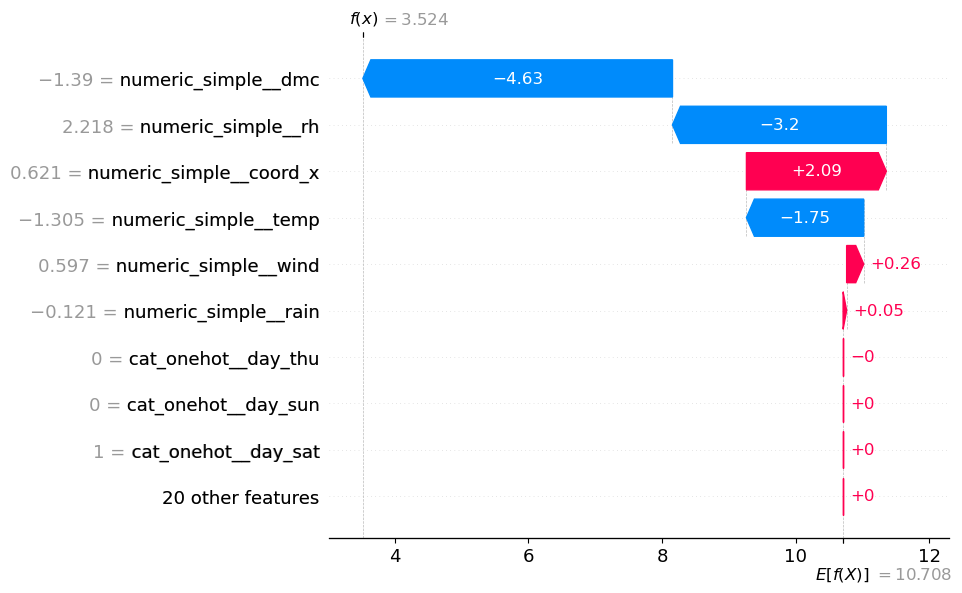

In [31]:
shap.plots.waterfall(shap_values[0])

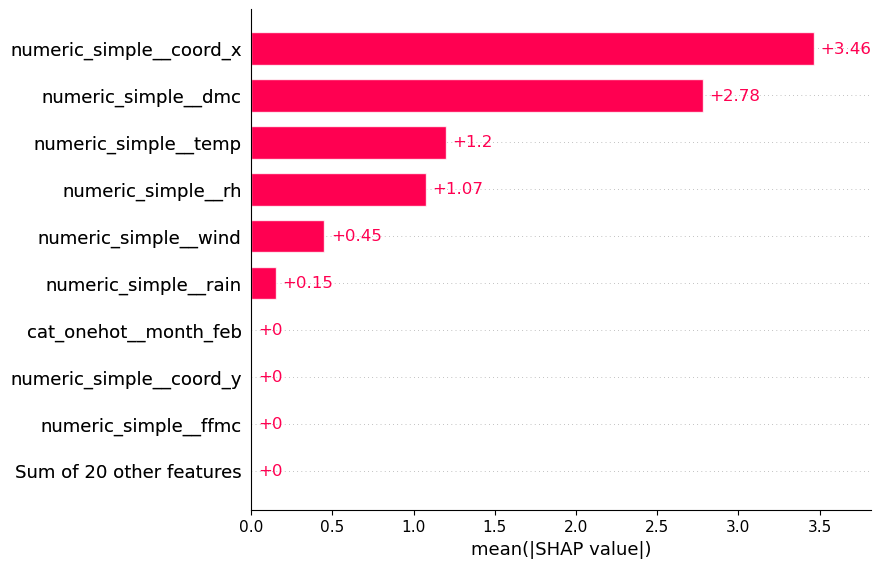

In [32]:
# shap.waterfall_plot(shap_values)
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

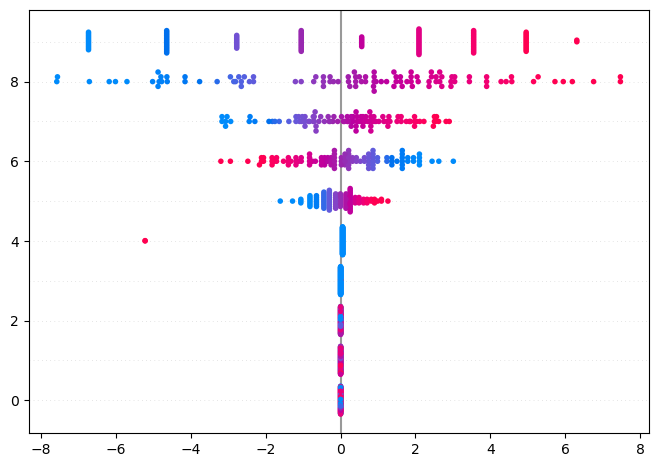

In [33]:
shap.plots.beeswarm(shap_values)

The most important features listed are these 6 features;<br> 
1- coord_x <br>
2- dmc <br>
3- rh<br>
4- wind <br>
5- Rain <br>

The top three among these feature are the ones hat have the most influence on the prediction: <br>
1- coord_x <br>
2- dmc <br>
3- rh <br>

The features that I would remove as they're not providing much influence (having the lowest SHAP values) are month_feb, coord_y, ffmc features.
The performance of the chosen model can be tested by removing the least influencing features and then measure the model performance using the same scoring criteria mentioned in the GridSearchCV code. If the removal of the feature enhances the model's performance then it is a good result, but if the removal of that feature worsen the model's performance then I'd retain it.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.